In [8]:
import keras
keras.__version__

'2.3.1'

### 使用预训练的卷积神经网络

#### 一、特征提取

In [9]:
#导入预训练模型VGG16模型的卷积基
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',  #制定模型初始化的权重检查点
                  include_top=False,   #不包含分类器。 ImageNet数据集包括1000个类别，这里只需2类
                  input_shape=(150, 150, 3))  #输入的图形张量形状

In [10]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

方法1:保存数据在 conv_base 中的输出，然后将这些输出作为输入用于新模型

In [11]:
#说明输入图片的路径
import os
import numpy as np

base_dir = 'D:/2021-2022学年 文件汇总/深度学习与应用实践/数据集/cats_and_dogs_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

In [12]:
#导入数据生成器
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rescale=1./255)  #定义图片生成器实例
batch_size = 20

#定义卷积基输出函数，返回特征图和标签，格式为(样本数,4,4,512)和标签(样本数)
def extract_features(directory, sample_count):  #directory参数是路径，sample_count是样本数
    features = np.zeros(shape=(sample_count, 4, 4, 512))  #定义输出特征图初值
    labels = np.zeros(shape=(sample_count))      #定义标签初值
    generator = datagen.flow_from_directory(   #动态生成每批20个样本的150*150图片及分类
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)  #调用conv_base.predict(输入数据)，得到输出的特征图
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:   #在读取完所有图像后结束循环
            #注意，这些生成器在循环中不断生成数据，所以你必须在读取完所有图像后终止循环
            break
    return features, labels   #返回特征图和标签

In [13]:
#调用卷积基输出函数分别提取训练集、验证集和测试集的特征(samples,4,4,512)
train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

#将提取的特征展平为(samples,8192),后面才能输入全连接层
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [16]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Instructions for updating:
Use tf.cast instead.
Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 1s 750us/step - loss: 0.6133 - acc: 0.6610 - val_loss: 0.4469 - val_acc: 0.8260
Epoch 2/30
2000/2000 [==============================] - 1s 484us/step - loss: 0.4369 - acc: 0.8005 - val_loss: 0.3723 - val_acc: 0.8470
Epoch 3/30
2000/2000 [==============================] - 1s 479us/step - loss: 0.3571 - acc: 0.8490 - val_loss: 0.3288 - val_acc: 0.8680
Epoch 4/30
2000/2000 [==============================] - 1s 481us/step - loss: 0.3218 - acc: 0.8640 - val_loss: 0.3055 - val_acc: 0.8770
Epoch 5/30
2000/2000 [==============================] - 1s 483us/step - loss: 0.2825 - acc: 0.8830 - val_loss: 0.3095 - val_acc: 0.8660
Epoch 6/30
2000/2000 [==============================] - 1s 489us/step - loss: 0.2623 - acc: 0.8955 - val_loss: 0.2862 - val_acc: 0.8830
Epoch 7/30
2000/2000 [==============================] - 1s 482us/step - loss: 0.2436 - a

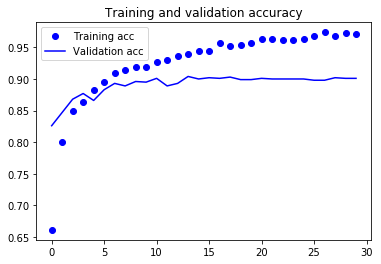

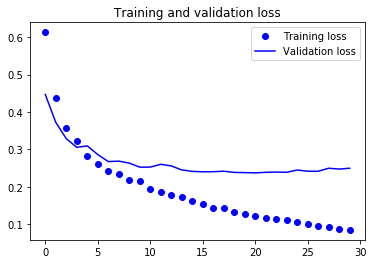

In [18]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

方法2:扩展 conv_base 模型，然后在输入数据上端到端地运行模型

In [19]:
from keras import models
from keras import layers

model = models.Sequential()
#添加卷积基并冻结
model.add(conv_base)
conv_base.trainable = False  #冻结卷积基，不参与训练
#添加Dense层
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
#增强数据
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(   #定义训练集生成器，设置数据增强
      rescale=1./255, 
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1./255)  #定义验证集生成器，不能设置数据增强

#动态生成数据
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')  #因为使用了 binary_crossentropy损失，所以需要用二进制标签

validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')


#编译模型
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])
#训练模型
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#### 二、微调模型

微调网络的步骤如下。

* (1) 在已经训练好的基网络上添加自定义网络。
* (2) 冻结基网络。
* (3) 训练所添加的部分。
* (4) 解冻基网络的一些层。
* (5) 联合训练解冻的这些层和添加的部分。 在做特征提取时已经完成了前三个步骤。继续进行第四步：先解冻 conv_base，然后冻结其中的部分层。

In [ ]:
#从顶层开始解冻直到 'block5_conv1'，将在前面已经训练好分类器的模型上，解冻卷积块5(包括3个卷积层和1个 Pooling 层)
conv_base.trainable = True  #解冻卷积基
set_trainable = False  #定义逻辑变量

#循环从 block1_conv1 开始，直到 block5_conv1 将 set_trainable 设为 true，此后各层均layer.trainable = True
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True  #设置该层解冻
    else:
        layer.trainable = False  #设置该层冻结

In [ ]:
#模型微调
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),  #设置非常小的学习率，避免权重变化太大
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
#绘制平滑曲线，用前一个点的指数移动平均值替换当前点
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
#在测试集上评估模型性能
test_datagen = ImageDataGenerator(rescale=1./255)  #定义验证集生成器，不能设置数据增强
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)